In [1]:
import numpy as np

from scipy import interpolate
from scipy import optimize

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

In [2]:
# Way Point locations
ax = [0.0, 6.0, 12.5, 5.0, 7.5, 3.0, -1.0]
ay = [0.0, 0.0, 5.0, 6.5, 3.0, 5.0, -2.0]

# Convert to numpy arrays
x, y = map(np.asarray, (ax, ay))

# Cumalitive distance traveled between waypoints
s = np.append([0],(np.cumsum(np.diff(x)**2) + np.cumsum(np.diff(y)**2))**0.5)


X = interpolate.CubicSpline(s, x)
Y = interpolate.CubicSpline(s, y)

dX = X.derivative(1)
ddX = X.derivative(2)




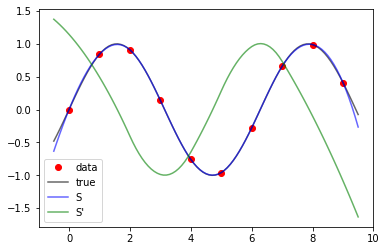

In [3]:
x = np.arange(10)
y = np.sin(x)
cs = interpolate.CubicSpline(x,y, bc_type='not-a-knot')
#cs = interpolate.CubicSpline(x,y, bc_type='natural')
xs = np.arange(-0.5, 9.6, 0.1)

fig,ax = plt.subplots()
ax.plot(x,y, 'ro',label='data')
ax.plot(xs, np.sin(xs), 'k-', alpha = 0.6, label='true')
ax.plot(xs, cs(xs), 'b-', alpha = 0.6, label='S')
ax.plot(xs, cs(xs,1), 'g-', alpha=0.6, label="S'")
ax.legend()

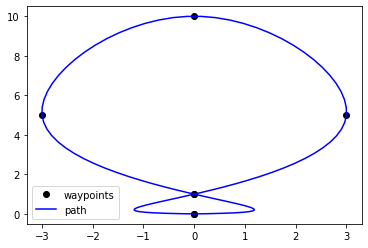

In [4]:
width = 6
height = 10
s1 = 1

waypoints_x = np.array([0, 0,  width/2, 0, -width/2, 0, 0])
waypoints_y = np.array([0, s1, height/2, height, height/2, s1, 0])
N = len(waypoints_x)

# Waypoint index
s = np.arange(N)/(N-1)


# Fit splines s -> x,y
X = interpolate.CubicSpline(s, waypoints_x,extrapolate=False)
Y = interpolate.CubicSpline(s, waypoints_y,extrapolate=False)


ss = np.linspace(0.0,1,100)
sx = X(ss)
sy = Y(ss)


fig,ax = plt.subplots()
ax.plot(waypoints_x, waypoints_y, 'ko', label='waypoints')
ax.plot(sx, sy, 'b-', label='path')
ax.legend()

In [5]:
class GuidanceUTurn:
    def __init__(self, vMag, d, R, loc, heading, spline_dt, window_size):

        if R <= 0:
            raise ValueError("R must be greater than 0")

        if d <= 0:
            raise ValueError("d must be greater than 0")

        # Store inputs
        self.d = d
        self.R = R
        self.vMag = vMag
        self.loc = np.asarray(loc)
        self.path_heading = heading
        self.spline_dt = spline_dt
        self.window_size = window_size

        # Setup U-Turn path and generate waypoints
        self.set_path()
        self.set_waypoints()

        self.kTarget_prev = 0


    def set_path(self):
        """ U-Turn Path consisting of 6 segments """

        # Define Guidance frame (G) DCM
        ch = np.cos(self.path_heading)
        sh = np.sin(self.path_heading)
        self.C_toGfromL = np.array([
            [ ch, sh],
            [-sh, ch],
        ],dtype=float)

        # Setup path
        theta = np.pi/3
        sth = np.sin(theta)

        # Path segments in Guidance frame
        path_segments_G = []

        # Path 1
        x = np.linspace(0, self.d, 1000)
        y = 0*x

        path1 = np.array([x,y]).T
        self.path1_start = 0.0
        self.path1_end = self.d

        # Path 2
        a2 = 0
        b2 = self.R*sth
        offset2 = np.array([self.d, 0])

        x = np.linspace(a2,b2)
        y = -np.sqrt(self.R**2 - x**2) + self.R

        path2 = np.array([x,y]).T + offset2
        self.path2_start = self.path1_end
        self.path2_end = self.path2_start + self.R*theta

        # Path 3
        a3 = -b2
        b3 = self.R
        offset3 = np.array([2*self.R*sth + self.d, 0])

        x = np.linspace(a3, b3, 1000)
        y = np.sqrt(self.R**2 - x**2)
        path3 = np.array([x,y]).T + offset3
        self.path3_start = self.path2_end
        self.path3_end = self.path3_start + self.R*(np.pi-theta/2)

        # Path 4
        path4 = path3[::-1] * np.array([1,-1])
        self.path4_start = self.path3_end
        self.path4_end = self.path4_start + self.R*(np.pi-theta/2)

        # Path 5
        path5 = path2[::-1] * np.array([1,-1])
        self.path5_start = self.path4_end
        self.path5_end = self.path5_start + self.R*theta

        # Path 6
        path6 = path1[::-1]
        self.path6_start = self.path5_end
        self.path6_end = self.path6_start + self.d

        path_segments_G = [
                path1[:-1],
                path2[:-1],
                path3[:-1],
                path4[:-1],
                path5[:-1],
                path6[:-1],
        ]

        # Transform each segment to world frame from guidance frame
        self.path_segments = [np.dot(self.C_toGfromL.T, pk.T).T + self.loc for pk in path_segments_G]

        # Transform path to L from G
        self.path = np.vstack(self.path_segments)

        # Total Travel
        self.travel = self.path6_end

    def set_waypoints(self):
        """ Set waypoints for path as function of progress along path

        waypoints = {x,y,psi,psiDot}

        """

        # Cumulative distance traveled
        dx = np.diff(self.path[:,0])
        dy = np.diff(self.path[:,1])
        ds = np.sqrt(dx**2 + dy**2)
        self.s  = np.hstack((0, np.cumsum(ds)))

        # Spline independent variable
        spline_t = self.s/self.s[-1]

        # Fit cubic splines
        self.Xfit = interpolate.CubicSpline(spline_t,self.path[:,0],extrapolate=False)
        self.Yfit = interpolate.CubicSpline(spline_t,self.path[:,1],extrapolate=False)

        # Calc waypoints from splines
        # Independent variable
        self.spline_t = np.arange(0, 1+self.spline_dt, self.spline_dt)
        self.spline_t[-1] = 1.0

        # Position waypoints
        self.waypoints_x = self.Xfit(self.spline_t)
        self.waypoints_y = self.Yfit(self.spline_t)

        # Psi waypoints
        dx = self.Xfit.derivative(1)(self.spline_t)
        dy = self.Yfit.derivative(1)(self.spline_t)
        self.waypoints_heading = np.arctan2(dy,dx)

        # PsiDot waypoints
        k_path6 = self.spline_t >= self.path6_start
        k_path5 = np.logical_and(self.spline_t >= self.path5_start, self.spline_t < self.path6_start)
        k_path4 = np.logical_and(self.spline_t >= self.path4_start, self.spline_t < self.path5_start)
        k_path3 = np.logical_and(self.spline_t >= self.path3_start, self.spline_t < self.path4_start)
        k_path2 = np.logical_and(self.spline_t >= self.path2_start, self.spline_t < self.path3_start)
        k_path1 = self.spline_t < self.path2_start

        psiDot = np.zeros_like(self.spline_t)
        # On Path6 (Straight)
        psiDot[k_path6] = 0.0
        # On Path5 (Turn Left)
        psiDot[k_path5] = self.vMag/self.R
        # On Path4 (Turn Right)
        psiDot[k_path4] = -self.vMag/self.R
        # On Path3 (Turn Right)
        psiDot[k_path3] = -self.vMag/self.R
        # On Path2 (Turn Left)
        psiDot[k_path2] = self.vMag/self.R
        # On Path1 (Straight)
        psiDot[k_path1] = 0.0

        self.waypoints_headingRate = psiDot

        # Setup window
        self.n_points = len(self.spline_t)
        self.window = np.array([False]*self.n_points)
        self.window_width = int(self.window_size/self.spline_dt)


    def update(self, point, heading, headingRate):

        point = np.asarray(point)

        # Reset window
        self.window.fill(False)

        # Indices for window, with previous point as mid point of window
        kStart = self.kTarget_prev - int(self.window_width/2)
        if kStart < 0:
            kStart = 0

        kEnd = kStart + self.window_width
        if kEnd > self.n_points:
            kEnd = self.n_points
            kStart = kEnd - self.window_width

        # Set window
        self.window[kStart:kEnd] = True

        # Find index of closest point within window
        dx = point[0] - self.waypoints_x[self.window]
        dy = point[1] - self.waypoints_y[self.window]
        dist = np.sqrt(dx**2 + dy**2)
        kTarget_window = np.argmin(dist)

        # Adjust for use with full array
        kTarget = kTarget_window + kStart

        # Dont look back at previous waypoints
        if kTarget < self.kTarget_prev:
            kTarget = self.kTarget_prev

        # Progress
        progress = self.spline_t[kTarget]

        # Heading and position error
        target_heading = self.waypoints_heading[kTarget]
        target_err = point - np.array([self.waypoints_x[kTarget],self.waypoints_y[kTarget]])

        # DCM from world/local frame to target waypoint
        ch = np.cos(target_heading)
        sh = np.sin(target_heading)
        C_toTargetfromL = np.array([
            [ ch, sh],
            [-sh, ch],
        ],dtype=float)

        # Error to waypoint in target waypoint frame
        err_target_waypointFrame = np.dot(C_toTargetfromL,target_err)
        cte = -err_target_waypointFrame[1]

        # Heading error and handle angle wrapping
        heading_error = target_heading - heading
        if heading_error > np.pi:
            heading_error -= 2*np.pi
        elif heading_error < -np.pi:
            heading_error += 2*np.pi

        # Target Heading Rate for current waypoint
        target_headingRate = self.waypoints_headingRate[kTarget]

        # Heading rate error
        headingRate_error = target_headingRate - headingRate

        self.kTarget_prev = kTarget

        return progress, cte, heading_error, headingRate_error


progress =  0.036000000000000004
cte =  -1.0
heading_error =  -1.0


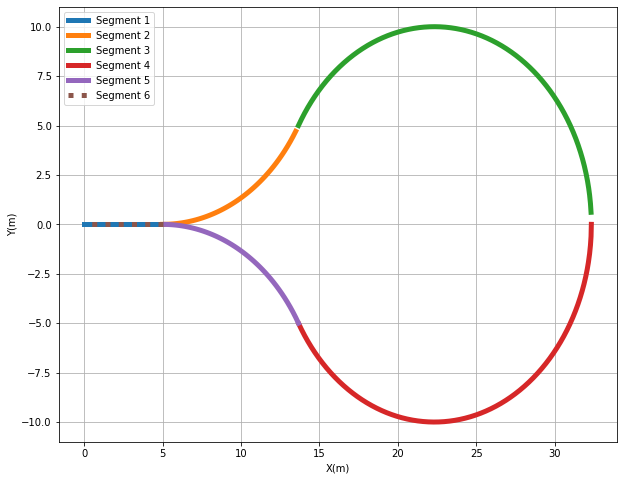

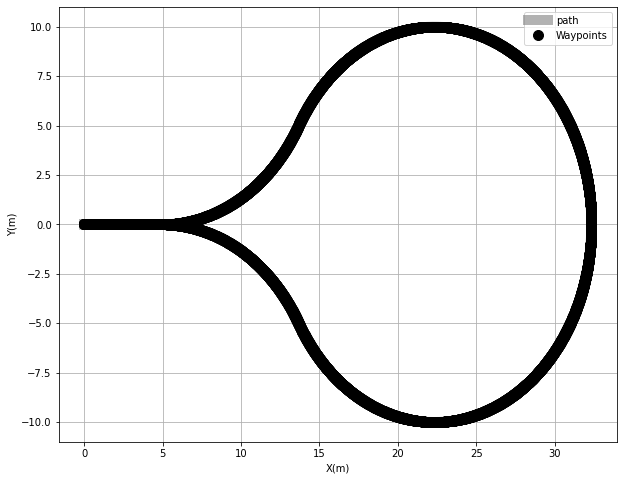

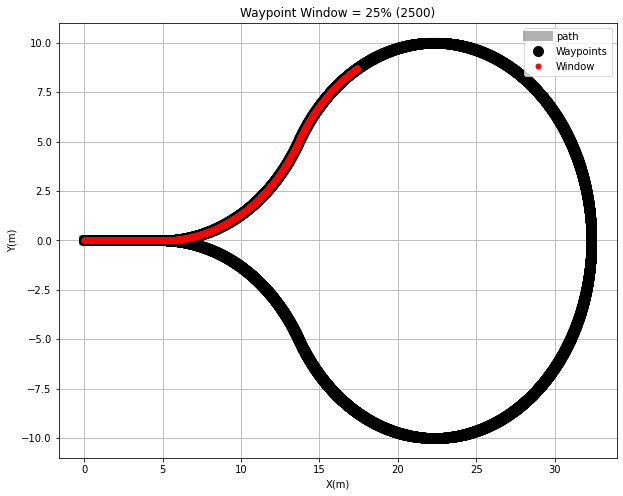

In [6]:
vMag = 20 / 3.6 # m/s
d = 5
R = 10
loc = (0,0)
heading = 0 * np.pi/180.0
spline_dt = 0.0001
window_size = 0.25

guidTurn = GuidanceUTurn(vMag,d,R,loc,heading,spline_dt,window_size)
t = np.linspace(0,1,1000)
dt = np.diff(t)[0]

fig,ax = plt.subplots(figsize=(10,8))

#ax.plot(guidTurn.path[:,0], guidTurn.path[:,1],'k',alpha=0.6,lw=10,zorder=-1,label='path')
#ax.plot(guidTurn.Xfit(t), guidTurn.Yfit(t),'y',alpha=0.6,lw=5,zorder=-1,label='fit')
for k,path_k in enumerate(guidTurn.path_segments):
    if k+1 == 6:
        ax.plot(path_k[:,0], path_k[:,1], lw=5, ls=':', label=f'Segment {k+1}')
    else:
        ax.plot(path_k[:,0], path_k[:,1], lw=5, label=f'Segment {k+1}')
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
ax.legend()
ax.grid()


point = (3,1)
heading = 1 * np.pi/180

progress, cte, heading_error, psiDot_error = guidTurn.update(point, heading, 0.0)
print('progress = ', progress)
print('cte = ', cte)
print('heading_error = ', heading_error*180/np.pi)


fig,ax = plt.subplots(figsize=(10,8))
ax.plot(guidTurn.path[:,0], guidTurn.path[:,1],'grey',alpha=0.6,lw=10,zorder=-1,label='path')
ax.plot(guidTurn.waypoints_x, guidTurn.waypoints_y, 'ko', ms=10, label='Waypoints')
#ax.plot(point[0], point[1],'bo',label='point')
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
ax.legend()
ax.grid()


fig,ax = plt.subplots(figsize=(10,8))
ax.set_title(f'Waypoint Window = {guidTurn.window_size*100:0.0f}% ({guidTurn.window_width})')
ax.plot(guidTurn.path[:,0], guidTurn.path[:,1],'grey',alpha=0.6,lw=10,zorder=-1,label='path')
ax.plot(guidTurn.waypoints_x, guidTurn.waypoints_y, 'ko', ms=10, label='Waypoints')
ax.plot(guidTurn.waypoints_x[guidTurn.window], guidTurn.waypoints_y[guidTurn.window], 'r.', ms=10, label='Window')
#ax.plot(point[0], point[1],'bo',label='point')
ax.set_xlabel('X(m)')
ax.set_ylabel('Y(m)')
ax.legend()
ax.grid()

#fig,ax = plt.subplots(figsize=(10,8))
#ax.plot(guidTurn.spline_t, guidTurn.waypoints_psiDot,'.')



5
15.471975511965976
41.65191429188092
67.83185307179586
78.30382858376184
83.30382858376184


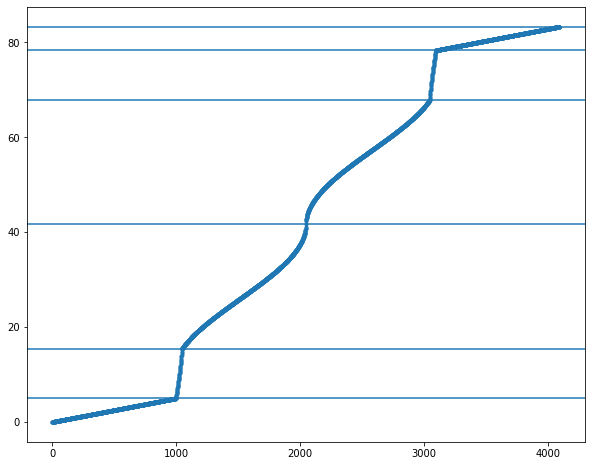

In [7]:
print(guidTurn.path1_end)
print(guidTurn.path2_end)
print(guidTurn.path3_end)
print(guidTurn.path4_end)
print(guidTurn.path5_end)
print(guidTurn.path6_end)

fig,ax = plt.subplots(figsize=(10,8))
ax.plot(guidTurn.s,'.')
ax.axhline(guidTurn.path1_end)
ax.axhline(guidTurn.path2_end)
ax.axhline(guidTurn.path3_end)
ax.axhline(guidTurn.path4_end)
ax.axhline(guidTurn.path5_end)
ax.axhline(guidTurn.path6_end)


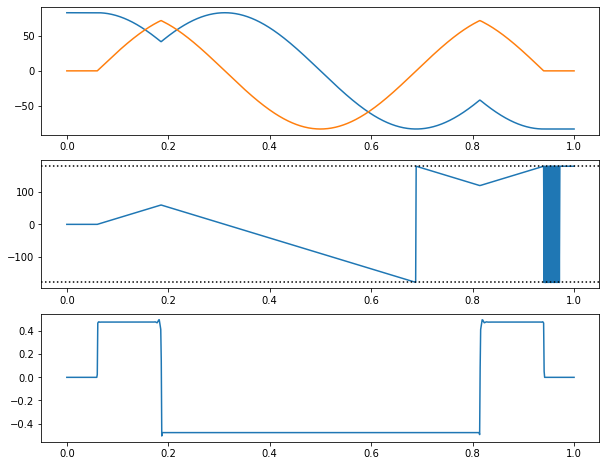

In [8]:
dx = guidTurn.Xfit.derivative(1)(t)

dy = guidTurn.Yfit.derivative(1)(t)

yaw = np.arctan2(dy,dx)

yawRate = np.hstack((0,np.diff(yaw)))

yawRate[yawRate>np.pi] = yawRate[yawRate>np.pi] - 2*np.pi
yawRate[yawRate<-np.pi] = yawRate[yawRate<-np.pi] + 2*np.pi

# if heading_error > np.pi:
#        heading_error -= 2*np.pi
#         elif heading_error < -np.pi:
#             heading_error += 2*np.pi


fig,ax = plt.subplots(3,1, figsize=(10,8))
ax[0].plot(t,dx)
ax[0].plot(t,dy)
ax[1].plot(t,yaw*180/np.pi)
ax[1].axhline(180,ls=':',color='k')
ax[1].axhline(-180,ls=':',color='k')
ax[2].plot(t,yawRate*180/np.pi)

path normal
<0.707, 0.707>


(-1.0, 1.0)

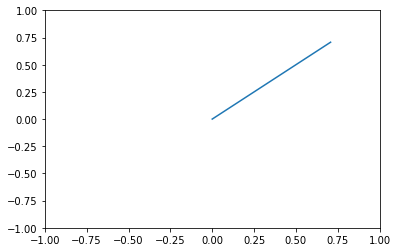

In [9]:
heading = -45 * np.pi/180

#path_tangent = np.array([dx[kTarget], dy[kTarget]])
path_normal = np.array([
    -np.sin(heading),
    np.cos(heading),
])

print("path normal")
print(f'<{path_normal[0]:0.3f}, {path_normal[1]:0.3f}>')

plt.plot([0,path_normal[0]], [0,path_normal[1]])
plt.xlim(-1,1)
plt.ylim(-1,1)

In [10]:
waypoints_x = np.array([0, 0,  width/2, 0, -width/2, 0, 0])
waypoints_y = np.array([0, s1, height/2, height, height/2, s1, 0])
N = len(waypoints_x)

# Waypoint index
s = np.arange(N)/(N-1)


# Fit splines s -> x,y
X = interpolate.CubicSpline(s, waypoints_x,extrapolate=False)
Y = interpolate.CubicSpline(s, waypoints_y,extrapolate=False)

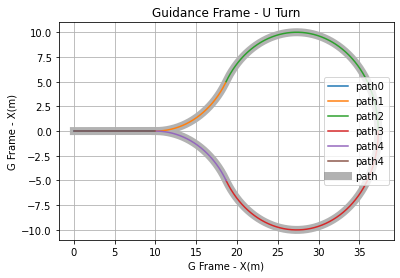

In [11]:
d = 10.0
R = 10.0

theta = np.pi/3

# 1
a0 = 0
b0 = d
offset0 = np.array([0,0])

x0 = np.linspace(a0,b0,1000)
y0 = 0*x0
path0 = np.array([x0,y0]).T + offset0

# 1
a1 = 0
b1 = R*np.sin(theta)
offset1 = np.array([d,0])

x1 = np.linspace(a1,b1,1000)
y1 = -np.sqrt(R**2 - x1**2) + R
path1 = np.array([x1,y1]).T + offset1

# 2
a2 = -b1
b2 = R
offset2 = np.array([2*R*np.sin(theta)+d,0])

x2 = np.linspace(a2, b2, 1000)
y2 = np.sqrt(R**2 - x2**2)
path2 = np.array([x2,y2]).T + offset2

# 3,4
path3 = path2[::-1] * np.array([1,-1])
path4 = path1[::-1] * np.array([1,-1])
path5 = path0[::-1]

path = np.vstack((path0,path1,path2,path3,path4))

fig,ax = plt.subplots()
ax.set_title('Guidance Frame - U Turn')
ax.plot(path0[:,0],path0[:,1],label='path0')
ax.plot(path1[:,0],path1[:,1],label='path1')
ax.plot(path2[:,0],path2[:,1],label='path2')
ax.plot(path3[:,0],path3[:,1],label='path3')
ax.plot(path4[:,0],path4[:,1],label='path4')
ax.plot(path5[:,0],path5[:,1],label='path4')
ax.plot(path[:,0],path[:,1],'grey',alpha=0.6,lw=8,zorder=-1,label='path')
ax.set_xlabel('G Frame - X(m)')
ax.set_ylabel('G Frame - X(m)')
ax.legend()
ax.grid()


ang = 45 * np.pi / 180




In [12]:

class GuidanceLine:
    def __init__(self, waypoint_A, waypoint_B):

        # Set waypoints
        self.set_waypoints(waypoint_A, waypoint_B)

    def set_waypoints(self, waypoint_A, waypoint_B):
        """Initialize guidance line

        waypoints A and B defined in world/local coordinate frame

        """
        # Store waypoints
        self.waypoint_A = np.asarray(waypoint_A,dtype=float)
        self.waypoint_B = np.asarray(waypoint_B,dtype=float)

        # Path vector
        self.path = self.waypoint_B - self.waypoint_A

        # Path heading
        self.heading = np.arctan2(self.path[1], self.path[0])

        # Precompute for orthogonal projection
        self._path_dot_path = np.dot(self.path, self.path)
        self.path_dist = np.sqrt(self._path_dot_path)

        # Define DCMs
        ch = np.cos(self.heading)
        sh = np.sin(self.heading)

        self.C_toLfromB = np.array([
            [ch, -sh],
            [sh,  ch],
        ], dtype=float)

        self.C_toBfromL = self.C_toLfromB.T

    def update(self, point):
        """Returns the perpendicular distance between point and line"""
        point = np.asarray(point)

        tp = np.dot((point-self.waypoint_A), self.path) / self._path_dot_path
        point_on_path = self.waypoint_A + tp*self.path
        dist_vec = point - point_on_path

        dist = np.sqrt(np.dot(dist_vec, dist_vec))

        return tp, dist, dist_vec



In [13]:
waypoint_A = (0,0)
waypoint_B = (10,10)


# Init waypoints
waypoint_A = np.asarray(waypoint_A,dtype=float)
waypoint_B = np.asarray(waypoint_B,dtype=float)

path_vec = waypoint_B - waypoint_A
path_length = np.sqrt(np.dot(path_vec, path_vec))

heading = np.arctan2(path_vec[1], path_vec[0])
ch = np.cos(heading)
sh = np.sin(heading)

C_toLfromG = np.array([
    [ch, -sh],
    [sh,  ch],
], dtype=float)

C_toGfromL = C_toLfromG.T

# Update
point = (1,0.5)

point = np.asarray(point) # L frame

# Transform point to Guidance frame
point = point - waypoint_A
point_G = np.dot(C_toGfromL, point)

tp = point_G[0]/path_length
cte = point_G[1]

print(f"tp  = {tp:0.3}")
print(f"cte = {cte:0.3}")


tp  = 0.075
cte = -0.354


In [14]:

class GuidanceLine:
    def __init__(self, waypoint_A, waypoint_B):

        # Set waypoints
        self.set_waypoints(waypoint_A, waypoint_B)

    def set_waypoints(self, waypoint_A, waypoint_B):
        """Initialize guidance line

        waypoints A and B defined in world/local coordinate frame

        """
        # Store waypoints
        self.waypoint_A = np.asarray(waypoint_A,dtype=float)
        self.waypoint_B = np.asarray(waypoint_B,dtype=float)

        # Path vector (Straight line path)
        self.path = self.waypoint_B - self.waypoint_A
        self.path_length = np.sqrt(np.dot(self.path, self.path))

        # Path heading
        self.path_heading = np.arctan2(self.path[1], self.path[0])
        print(self.path_heading*180/np.pi)

        # Define Guidance frame (G) DCM
        ch = np.cos(self.path_heading)
        sh = np.sin(self.path_heading)
        self.C_toGfromL = np.array([
            [ ch, sh],
            [-sh, ch],
        ],dtype=float)

    def update(self, point, heading):
        """Returns the perpendicular distance between point and line"""

        # Point in world/local frame
        point = np.asarray(point)

        # Transform point to Guidance frame (G)
        point = point - self.waypoint_A
        point_G = np.dot(self.C_toGfromL, point)

        # Normalized distance along path
        path_dist = point_G[0] / self.path_length

        # Cross track error (Perpendicular distance from point to line)
        cte = -point_G[1]

        # Heading error
        heading_error = self.path_heading - heading
        if heading_error > np.pi:
            heading_error -= 2*np.pi
        elif heading_error < -np.pi:
            heading_error += 2*np.pi

        return path_dist, cte, heading_error




-135.0
progress      =  0.06249999999999999
cte           =  0.06249999999999999
heading_error =  -135.0
path_heading  =  -135.0


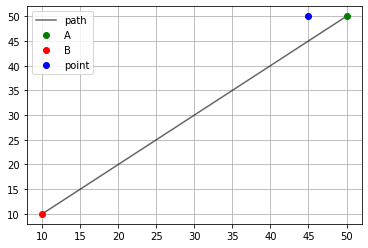

In [15]:
waypoint_B = (10,10)
waypoint_A = (50,50)

guid = GuidanceLine(waypoint_A, waypoint_B)

point = (45,50)
progress, cte, heading_error = guid.update(point, 0)

print(f"progress      = ", progress)
print(f"cte           = ", progress)
print(f"heading_error = ", heading_error*180/np.pi)
print(f"path_heading  = ", guid.path_heading*180/np.pi)




path = np.array([waypoint_A, waypoint_B])
fig,ax = plt.subplots()
ax.plot(path[:,0], path[:,1],'k-',alpha=0.6,label='path')
ax.plot(*waypoint_A,'go',label='A')
ax.plot(*waypoint_B,'ro',label='B')
ax.plot(*point,'bo', label='point')
ax.legend()
ax.grid()

In [16]:
a = np.array([0,1])
b = np.array([0,-2])

test = np.dot(a,b)
test

-2

In [17]:
theta = np.pi/4
ct = np.cos(theta)
st = np.sin(theta)
R_fromBtoL = np.array([
    [ct, -st],
    [st,  ct],
])

R_fromLtoB = R_fromBtoL.T

x_B = np.array([1,0])
x_L = np.dot(R_fromBtoL, x_B)

In [18]:
point_L = np.array([1,1])

point_B = np.dot(R_fromLtoB, point_L)

print("point")
print(f"L = {point_L}")
print(f"B = {point_B}")

point
L = [1 1]
B = [1.41421356e+00 1.11022302e-16]
